In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


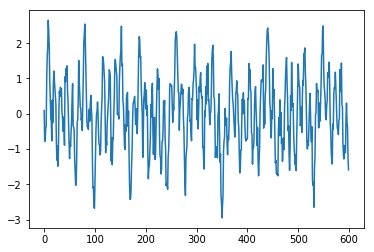

In [44]:
t = 2 * np.pi * np.arange(7800) / 12
signal = np.cos(t) + 0.8 * np.cos(t / 3 + 0.1) + 0.5 * np.cos(t / 5 + 0.2) + 0.3 * np.cos(t / 11 + 0.3) + 0.1 * np.cos(t / 17 + 0.4) + 0.3 * np.random.normal(0, 1, 7800)

plt.plot(signal[100:700]);

In [45]:
mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

In [46]:
T = 1      # prediction timeline
H = 48   # history used for prediction
include_month = 0

In [47]:
np.random.seed(0)

size = signal.shape[0] - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H + include_month))
for i in range(size):
    if(include_month == False):
         data[i] = signal[i:(i + H)]
    else:
        data[i] = np.append(signal[i:(i + H)], (i + H + T) % 12)

labels = np.ndarray((size), dtype = np.float64)
        
for i in range(size):
    labels[i] = signal[i + H + T]

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

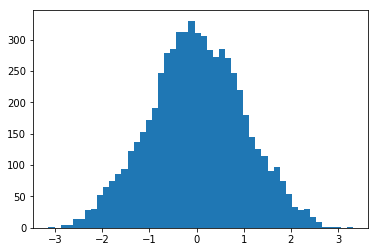

In [48]:
plt.hist(train_labels, bins=50);

In [56]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 25

model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
        ])

model.reset_states()

model.compile(optimizer='adam',
                    loss='mae',
                    metrics=['mse', 'mae'])

model.fit(train, train_labels, epochs = epochs, verbose = 1)
(loss, mse, mae) = model.evaluate(val, val_labels, verbose = 0)

print(mse, mae)

Epoch 1/25
6200/6200 [==============================] - 3s 534us/step - loss: 0.3327 - mean_squared_error: 0.1786 - mean_absolute_error: 0.3327
Epoch 2/25
6200/6200 [==============================] - 3s 452us/step - loss: 0.2892 - mean_squared_error: 0.1316 - mean_absolute_error: 0.2892
Epoch 3/25
6200/6200 [==============================] - 2s 376us/step - loss: 0.2848 - mean_squared_error: 0.1291 - mean_absolute_error: 0.2848
Epoch 4/25
6200/6200 [==============================] - 2s 365us/step - loss: 0.2767 - mean_squared_error: 0.1220 - mean_absolute_error: 0.2767
Epoch 5/25
6200/6200 [==============================] - 2s 370us/step - loss: 0.2728 - mean_squared_error: 0.1190 - mean_absolute_error: 0.2728
Epoch 6/25
6200/6200 [==============================] - 2s 368us/step - loss: 0.2704 - mean_squared_error: 0.1173 - mean_absolute_error: 0.2704
Epoch 7/25
6200/6200 [==============================] - 3s 422us/step - loss: 0.2702 - mean_squared_error: 0.1162 - mean_absolute_error:

In [63]:
pred = model.predict(train)

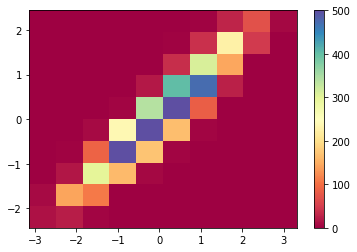

In [64]:
plt.hist2d(train_labels, pred[:,0], cmap = plt.cm.Spectral, vmax = 500);
plt.colorbar();

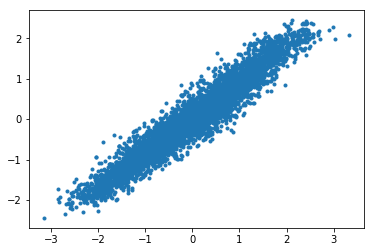

In [65]:
plt.plot(train_labels, pred[:,0], ".");

In [66]:
val_pred = model.predict(val)

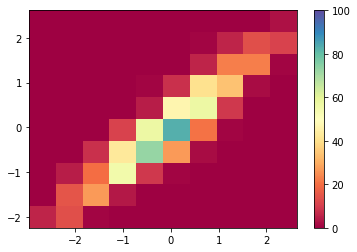

In [67]:
plt.hist2d(val_labels, val_pred[:,0], cmap = plt.cm.Spectral, vmax = 100);
plt.colorbar();

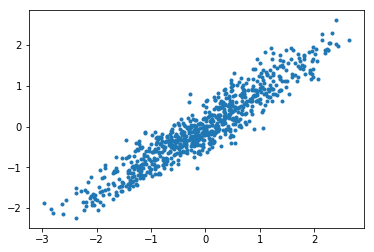

In [68]:
plt.plot(val_labels, val_pred[:,0], ".");